In [6]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.6.0+cpu
CUDA available: False


In [1]:
from FlagEmbedding import BGEM3FlagModel
import pandas as pd 

# df = pd.read_csv(r"docs\Google Ads desk.csv", skiprows=1)  
# df = df.dropna(subset=["Keyword"]) # 删除空值行
# search_terms = df["Keyword"].tolist()  # 提取表头为"keyword"的列，并转换为列表


df = pd.read_csv('amz_bsr_reviews_points.csv')  
exp_points = df['体验点'].dropna().tolist()  # 删除空值并转为列表


model = BGEM3FlagModel('BAAI/bge-m3',  
                       use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation
embeddings = model.encode(exp_points, batch_size=12, max_length=1024)['dense_vecs']

FileNotFoundError: [Errno 2] No such file or directory: 'amz_bsr_reviews_points.csv'

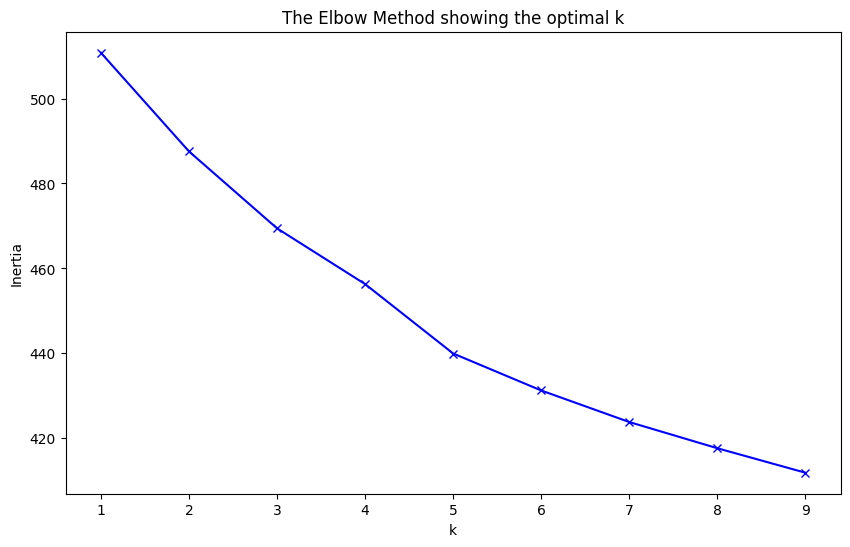

In [10]:
# ========== kmeans 1 ==========
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score


# Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10)
    km.fit(embeddings)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [16]:
# ========== kmeans 2 ==========
num_clusters = 6
km = KMeans(n_clusters=num_clusters)
km.fit(embeddings)


#量化聚类效果
print("Inertia（越小越好）:", km.inertia_) #均方误差 (Inertia, SSE)

clusters = km.fit_predict(embeddings)  # 获取每个数据点的簇编号
silhouette_avg = silhouette_score(embeddings, clusters) #轮廓系数 (Silhouette Score)
print(f"Silhouette Score（越接近1越好）: {silhouette_avg:.4f}")

ch_score = calinski_harabasz_score(embeddings, clusters)  # CH 指数 (Calinski-Harabasz Index)
print(f"Calinski-Harabasz Index（越大越好）: {ch_score:.4f}")

db_score = davies_bouldin_score(embeddings, clusters)  # DB 指数 (Davies-Bouldin Index)
print(f"Davies-Bouldin Index（越小越好）: {db_score:.4f}")


Inertia（越小越好）: 438.4798889160156
Silhouette Score（越接近1越好）: 0.0673
Calinski-Harabasz Index（越大越好）: 46.3392
Davies-Bouldin Index（越小越好）: 2.9039


In [17]:
# ========== TF-IDF主题词提取 ==========
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 合并自定义停用词
custom_stop_words = ["desk", "desks", "furniture", "executive", "table","tables","chair","chairs"]
stop_words = list(set(ENGLISH_STOP_WORDS).union(set(custom_stop_words)))

# 获取聚类标签并整理各簇文本
clusters = km.labels_.tolist()
cluster_texts = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(clusters):
    cluster_texts[label].append(search_terms[idx])

# 将每个簇的搜索词合并为一个"文档"
cluster_documents = []
for cluster_id in range(num_clusters):
    # 将簇内所有搜索词用空格连接，保留原始短语结构
    cluster_doc = " ".join(cluster_texts[cluster_id])
    cluster_documents.append(cluster_doc)

# 全局TF-IDF计算
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 3),  # 保持短语检测能力
    max_df=0.85,         # 过滤出现在85%以上簇中的常见词
    min_df=1             # 允许出现1次的词（小簇需要）
)
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_documents)
feature_names = tfidf_vectorizer.get_feature_names_out()

# 为每个簇提取主题词
for cluster_id in range(num_clusters):
    try:
        # 获取当前簇的TF-IDF向量
        cluster_tfidf = tfidf_matrix[cluster_id].toarray().flatten()
        
        # 按TF-IDF值降序排序
        sorted_indices = np.argsort(cluster_tfidf)[::-1]
        
        # 提取前10个候选词
        top_candidates = [feature_names[i] for i in sorted_indices[:10]]
        
        # 验证候选词是否实际存在于原始搜索词中
        valid_keywords = []
        original_terms = " ".join(cluster_texts[cluster_id]).lower()
        for candidate in top_candidates:
            # 检查候选词是否作为完整短语或单词存在于原始搜索词
            if any(
                candidate.lower() == term.lower() or 
                candidate.lower() in term.lower().split()
                for term in cluster_texts[cluster_id]
            ):
                valid_keywords.append(candidate)
        
        # 最终取前5个有效词
        final_keywords = valid_keywords[:5]
        
        # 打印结果
        print(f"\nCluster {cluster_id}（包含{len(cluster_texts[cluster_id])}个搜索词）")
        print("代表性搜索词:", ", ".join(cluster_texts[cluster_id][:5]) + "...")
        print("TF-IDF主题词:", ", ".join(final_keywords))
        print("─" * 80)
        
    except Exception as e:
        print(f"处理簇 {cluster_id} 时发生错误: {str(e)}")


Cluster 0（包含144个搜索词）
代表性搜索词: ikea desk, ikea chairs office, ikea desk with drawers, ikea desk top, ikea corner desk...
TF-IDF主题词: ikea, idasen, magnus, bekant, ikea micke
────────────────────────────────────────────────────────────────────────────────

Cluster 1（包含45个搜索词）
代表性搜索词: l shaped desk, l desk, l shaped desk with drawers, l shaped standing desk, l shaped office desk...
TF-IDF主题词: shaped, shape
────────────────────────────────────────────────────────────────────────────────

Cluster 2（包含115个搜索词）
代表性搜索词: standing desk, stand up desk, sit stand desk, sit and stand desk, best standing desk...
TF-IDF主题词: standing, stand, laptop, sit, sit stand
────────────────────────────────────────────────────────────────────────────────

Cluster 3（包含702个搜索词）
代表性搜索词: desk, standup desks, computer desk, vanity desk, office desk...
TF-IDF主题词: corner, drawers, oak, inch, hutch
────────────────────────────────────────────────────────────────────────────────

Cluster 4（包含140个搜索词）
代表性搜索词: desk chair, o

In [ ]:
# #==========LDA提取主题词==========
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import CountVectorizer
# import numpy as np
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


# custom_stop_words = ["desk", "desks", "furniture","executive","table"]   # 自定义停用词列表
# stop_words = list(set(ENGLISH_STOP_WORDS).union(set(custom_stop_words)))  # 合并 "english" 停用词与自定义停用词

# # 获取每个搜索词所属的簇
# clusters = km.labels_.tolist()

# # 按簇收集搜索词
# cluster_texts = {i: [] for i in range(num_clusters)}
# for idx, label in enumerate(clusters):
#     cluster_texts[label].append(search_terms[idx])

# # 对每个簇单独进行LDA
# for cluster_id in cluster_texts:
#     # 获取当前簇的所有搜索词（每个词作为独立文档）
#     cluster_docs = cluster_texts[cluster_id]
    
#     if not cluster_docs:  # 跳过空簇
#         continue
    
#     # 独立向量化（仅用本簇词汇）
#     vectorizer = CountVectorizer(
#         stop_words=stop_words,
#         ngram_range=(1, 3),
#         max_features=1000  # 限制特征数量防止过拟合
#     )
#     try:
#         X = vectorizer.fit_transform(cluster_docs)
#     except ValueError:  # 处理无有效词汇的簇
#         print(f"Cluster {cluster_id} 无有效词汇")
#         continue
    
#     # 训练LDA
#     lda = LatentDirichletAllocation(
#         n_components=1, # 仅提取一个主题
#         learning_method="online",
#         random_state=42,
#         max_iter=1000
#     )
#     lda.fit(X)

#     # 提取主题词
#     terms = vectorizer.get_feature_names_out()
#     topic_weights = lda.components_[0]
#     top_indices = topic_weights.argsort()[::-1][:5]  # 取权重最高的5个词
#     top_words = [terms[i] for i in top_indices]
    
#     # 输出结果
#     print(f"\nCluster {cluster_id}")
#     print("搜索词样本：", ", ".join(cluster_docs[:10]))  # 显示前10个搜索词
#     print("主题词：", ", ".join(top_words))
#     print("-" * 80)


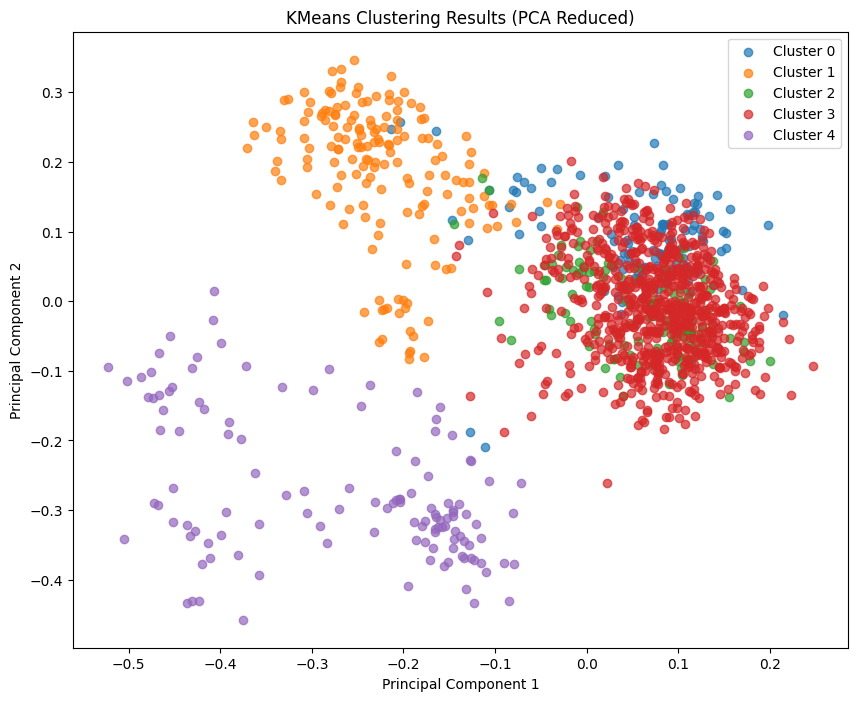

In [6]:
#可视化PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 假设 'embeddings' 是你从BGEM3模型中获得的词嵌入
# 假设 'clusters' 是你已经计算出的聚类标签

# 使用PCA降维
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(embeddings)

# 可视化聚类结果
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    # 获取每个簇的索引
    cluster_idx = [idx for idx, label in enumerate(clusters) if label == i]
    plt.scatter(reduced_embeddings_pca[cluster_idx, 0], reduced_embeddings_pca[cluster_idx, 1], label=f"Cluster {i}", alpha=0.7)

plt.title('KMeans Clustering Results (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


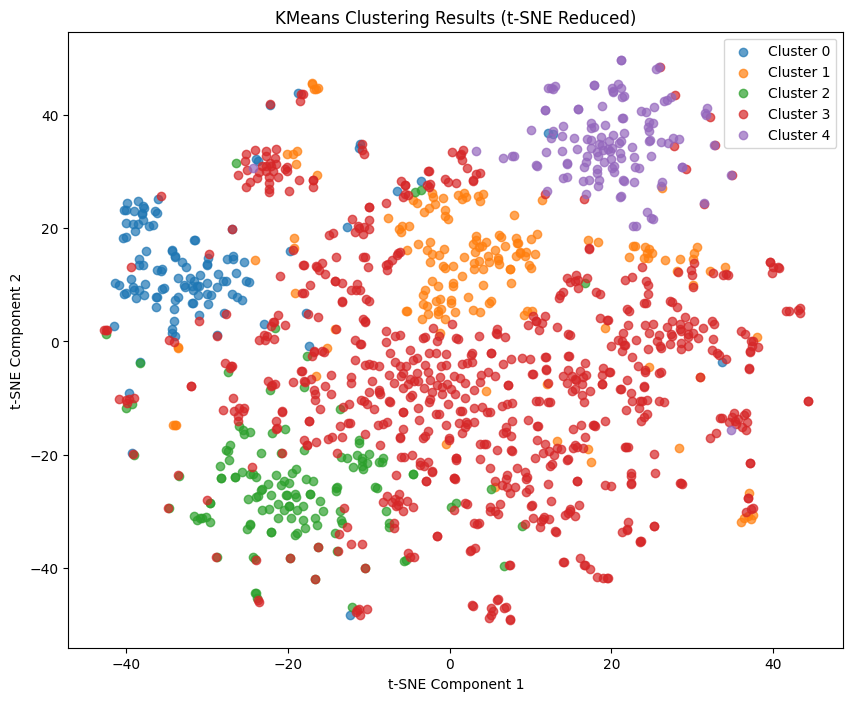

In [7]:
#可视化t-SNE
from sklearn.manifold import TSNE

# 使用t-SNE降维
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(embeddings)

# 可视化聚类结果
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    # 获取每个簇的索引
    cluster_idx = [idx for idx, label in enumerate(clusters) if label == i]
    plt.scatter(reduced_embeddings_tsne[cluster_idx, 0], reduced_embeddings_tsne[cluster_idx, 1], label=f"Cluster {i}", alpha=0.7)

plt.title('KMeans Clustering Results (t-SNE Reduced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


c:\Users\10345\.conda\envs\emb\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\10345\.conda\envs\emb\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


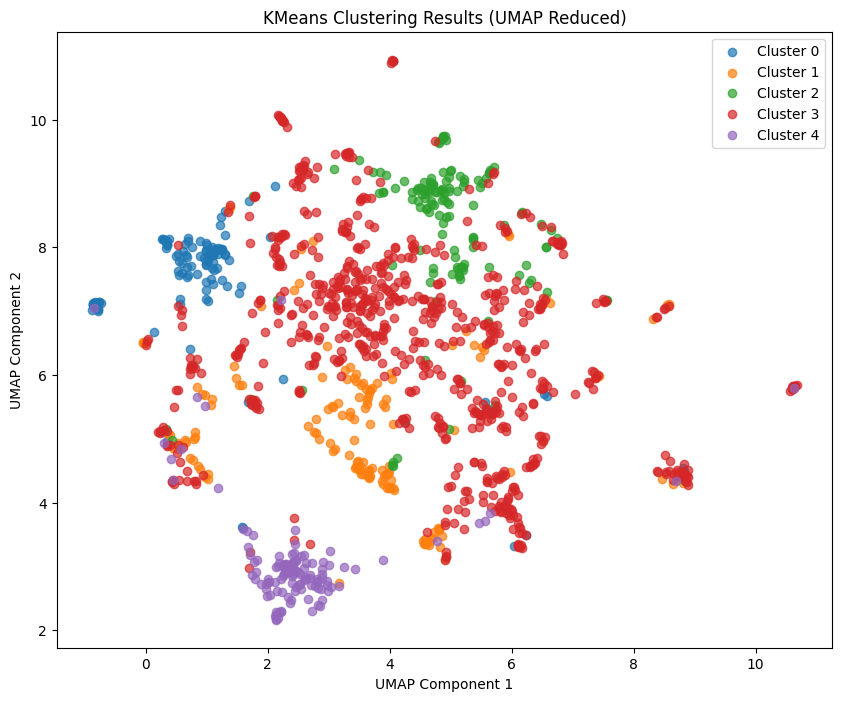

In [8]:
#可视化UMAP
import umap.umap_ as umap

# 使用UMAP降维
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings_umap = umap_model.fit_transform(embeddings)

# 可视化聚类结果
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    # 获取每个簇的索引
    cluster_idx = [idx for idx, label in enumerate(clusters) if label == i]
    plt.scatter(reduced_embeddings_umap[cluster_idx, 0], reduced_embeddings_umap[cluster_idx, 1], label=f"Cluster {i}", alpha=0.7)

plt.title('KMeans Clustering Results (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()
